In [2]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


from src.load_data import read_reviews, read_books, clean_reviews, clean_books

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.options.display.float_format = '{:,}'.format
# pd.set_option('display.max_colwidth', -1)

### Load reviews dataset

In [3]:
reviews_df = read_reviews(os.path.join('data/', 'goodreads_reviews_mystery_thriller_crime.json.gz'))

counting file: data/goodreads_reviews_mystery_thriller_crime.json.gz
current line: 0,1000000,complete
done!


In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849236 entries, 0 to 1849235
Data columns (total 7 columns):
review_id     object
user_id       object
book_id       object
rating        int64
timestamp     object
n_votes       int64
n_comments    int64
dtypes: int64(3), object(4)
memory usage: 98.8+ MB


In [5]:
num_reviews = len(reviews_df)
num_reviews

1849236

In [6]:
num_book = reviews_df.book_id.nunique()
num_user = reviews_df.user_id.nunique()

In [7]:
reviews_df.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments
0,5e212a62bced17b4dbe41150e5bb9037,8842281e1d1347389f2ab93d60773d4d,6392944,3,Mon Jul 24 02:48:17 -0700 2017,6,0
1,2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,3,Tue Nov 15 11:29:22 -0800 2016,22,0
2,8e4d61801907e591018bdc3442a9cf2b,8842281e1d1347389f2ab93d60773d4d,32283133,0,Tue Nov 01 11:09:18 -0700 2016,9,0
3,022bb6daffa49adc27f6b20b6ebeb37d,8842281e1d1347389f2ab93d60773d4d,17860739,4,Wed Mar 26 13:51:30 -0700 2014,7,0
4,0e317947e1fd341f573192111bb2921d,8842281e1d1347389f2ab93d60773d4d,8694005,3,Wed Sep 08 01:22:27 -0700 2010,17,6


In [8]:
user_dist = pd.DataFrame(reviews_df.user_id.value_counts()).reset_index()
user_dist.columns =['user_id', 'count']
user_dist.groupby('count').size()[:20]/num_user#.hist(bins=5)

count
1     0.36383589894674817
2     0.15935282708502124
3     0.09285310942525349
4    0.061127887849549485
5     0.04442316662983968
6     0.03416071297046476
7    0.026299378851489037
8      0.0216346271881368
9    0.017549286784021997
10   0.015045051680538164
11   0.012928727504848886
12   0.010689646706439812
13   0.009658491075593528
14   0.008484937762392281
15   0.007242640740467948
16   0.006623947361960178
17   0.006029805307996366
18   0.005695907294198522
19   0.004826790405342368
20   0.004762956961528075
dtype: float64

In [9]:
user_dist.head()

,user_id,count
0,a2d6dd1685e5aa0a72c9410f8f55e056,3485
1,fca26c34be8fe623ee340061f1281796,2377
2,795595616d3dbd81bd16b617c9a1fa48,1927
3,da1e69dbd8e0016bc5d39a9de2c3c753,1436
4,a45fb5d39a6a9857ff8362900790510a,1375


In [10]:
user_dist['count_bins'] = pd.cut(x=user_dist['count'], bins=[0, 1, 5, 10, 15, 20, 3485])

In [14]:
user_dist_count = user_dist.groupby('count_bins').count()

In [17]:
book_dist = pd.DataFrame(reviews_df.book_id.value_counts()).reset_index()
book_dist.columns =['book_id', 'count']
book_dist.groupby('count').size()#.hist(bins=5)

count
1        94626
2        35435
3        19418
4        12277
5         8629
         ...  
4541         1
4875         1
6702         1
9316         1
13402        1
Length: 636, dtype: int64

In [22]:
book_dist['count_bins'] = pd.cut(x=book_dist['count'], bins=[0, 1, 5, 10, 15, 20, 13402])
book_dist_count = book_dist.groupby('count_bins').count()
book_dist_count
book_dist_count.columns

Index(['book_id', 'count'], dtype='object')

In [46]:
user_book_count = pd.DataFrame({'num_users':user_dist_count['count'].values, 'num_books':book_dist_count['count'].values})
user_book_count

,num_users,num_books
0,74097,94626
1,72859,75759
2,23357,21150
3,9980,8479
4,5690,4547
5,17672,14426


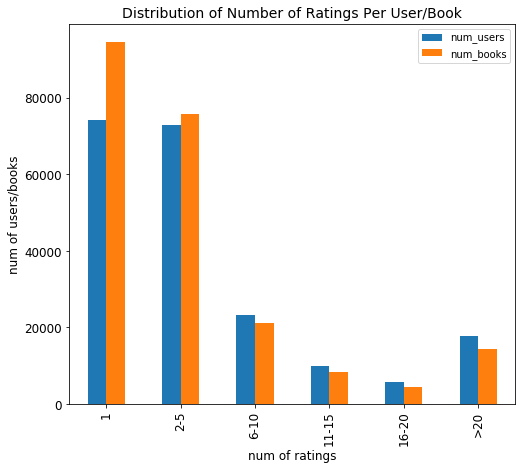

In [57]:
user_book_count['count_bins'] = ['1', '2-5', '6-10', '11-15', '16-20', '>20']
user_book_count.plot(kind='bar', x='count_bins', y= ['num_users', 'num_books'], fontsize = 12, figsize=(8,7))
plt.title('Distribution of Number of Ratings Per User/Book', fontsize = 14)
plt.xlabel('num of ratings', fontsize = 12)
plt.legend()
plt.ylabel('num of users/books',fontsize = 12)
plt.savefig('visualization/dist_of_num_ratings.png')


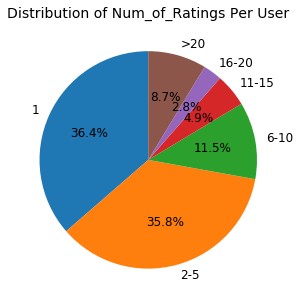

In [77]:
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.pie(user_book_count.num_users, labels=user_book_count.count_bins, startangle=90, autopct='%.1f%%', textprops={'fontsize': 12})
plt.title('Distribution of Num_of_Ratings Per User', fontsize = 14)
plt.savefig('visualization/pie_of_num_ratings_users.png');

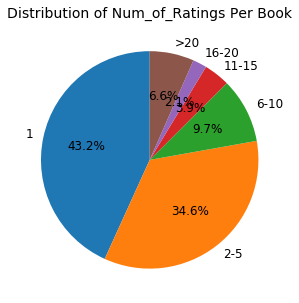

In [76]:
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.pie(user_book_count.num_books, labels=user_book_count.count_bins, startangle=90, autopct='%.1f%%', textprops={'fontsize': 12})
plt.title('Distribution of Num_of_Ratings Per Book', fontsize = 14)
plt.savefig('visualization/pie_of_num_ratings_books.png');

In [10]:
#We noticed there are reviews with a rate of zero.
#In Goodreads, the rating is from 1 to 5, so zero means missing value.
#We are going to delete those reviews considering the amount is small (3%)

reviews_df.rating[reviews_df.rating == 0].count()/num_reviews

0.03121126778842722

In [11]:
reviews_df1 = reviews_df[reviews_df.rating != 0]

In [12]:
reviews_df1.describe()

,rating,n_votes,n_comments
count,"1,791,519.0","1,791,519.0","1,791,519.0"
mean,3.802666898871851,1.105045494912418,0.27077859626384093
std,1.0281259804676335,6.3391224896565035,2.051866561544186
min,1.0,-3.0,-1.0
25%,3.0,0.0,0.0
50%,4.0,0.0,0.0
75%,5.0,1.0,0.0
max,5.0,904.0,348.0


In [13]:
len(reviews_df1.user_id.unique()), len(reviews_df1.book_id.unique())

(199757, 214260)

### rating distribution

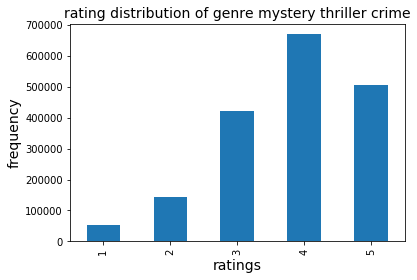

In [14]:
# rating distribution
reviews_df1.groupby('rating').size().plot(kind='bar')
plt.title('rating distribution of genre mystery thriller crime', fontsize=14)
plt.xlabel('ratings', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.savefig('genre_crime_rating_dist.png');

### n_votes

In [15]:
pct = reviews_df1[reviews_df1.n_votes > 0].groupby('n_votes').size().sum()/len(reviews_df1[reviews_df1.n_votes >= 0])
print('%.3f of reviews received votes'%pct)

0.258 of reviews received votes


In [16]:
print('the max number of votes a review received is %d'%reviews_df1.n_votes.max())

the max number of votes a review received is 904


In [18]:
# reviews_df1[reviews_df1.n_votes == reviews_df1.n_votes.max()].review_text

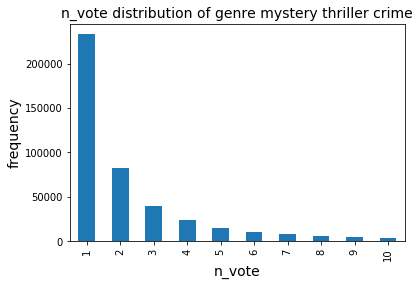

In [19]:
len(reviews_df1.n_votes.unique())
len(reviews_df1[reviews_df1.n_votes >= 0])
reviews_df1[reviews_df1.n_votes >= 0].groupby('n_votes').size()[1:11].plot(kind='bar')
plt.title('n_vote distribution of genre mystery thriller crime', fontsize=14)
plt.xlabel('n_vote', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.savefig('genre_crime_n_vote_dist.png');

### n_comments

In [20]:
pct = reviews_df1[reviews_df1.n_comments > 0].groupby('n_votes').size().sum()/len(reviews_df1[reviews_df1.n_comments >= 0])
print('%.3f of reviews received comments'%pct)

0.075 of reviews received comments


In [21]:
print('the max number of votes a review received is %d'%reviews_df1.n_comments.max())

the max number of votes a review received is 348


In [23]:
# reviews_df1[reviews_df1.n_comments == reviews_df1.n_comments.max()].review_text

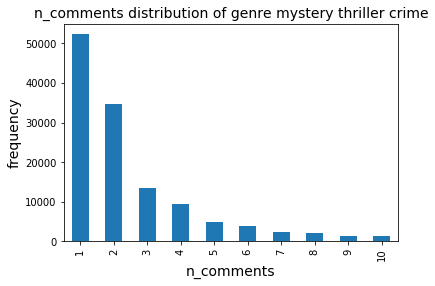

In [24]:
reviews_df1[reviews_df1.n_comments >= 0].groupby('n_comments').size()[1:11].plot(kind='bar')
plt.title('n_comments distribution of genre mystery thriller crime', fontsize=14)
plt.xlabel('n_comments', fontsize=14)
plt.ylabel('frequency', fontsize=14)
# plt.ylim(0, 200000)
plt.savefig('genre_crime_n_comments_dist.png');

### Load books dataset

In [25]:
books_df = read_books(os.path.join('data/', 'goodreads_books_mystery_thriller_crime.json.gz'), head=False)

counting file: data/goodreads_books_mystery_thriller_crime.json.gz
current line: 0,complete
done!


In [26]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219235 entries, 0 to 219234
Data columns (total 19 columns):
book_id               219235 non-null object
work_id               219235 non-null object
isbn                  219235 non-null object
asin                  219235 non-null object
title                 219235 non-null object
description           219235 non-null object
num_pages             219235 non-null object
is_ebook              219235 non-null object
link                  219235 non-null object
country_code          219235 non-null object
language_code         219235 non-null object
average_rating        219235 non-null object
ratings_count         219235 non-null object
text_reviews_count    219235 non-null object
author_id             219235 non-null object
publisher             219235 non-null object
publication_year      219235 non-null object
genre                 219235 non-null object
similar_books         219235 non-null object
dtypes: object(19)
memory usage: 3

In [27]:
num_books = len(books_df)
num_books

219235

In [28]:
books_df1 = books_df.copy()

### fill in missing page num with zero

In [29]:
books_df1.num_pages = books_df1.num_pages.replace(r'^\s*$', 0, regex=True)

In [30]:
len(books_df1.num_pages.unique())

1158

### concat genre

In [31]:
books_df1.genre[:1].values

array([list([{'count': '159', 'name': 'to-read'}, {'count': '12', 'name': 'historical-fiction'}, {'count': '11', 'name': 'mystery'}, {'count': '10', 'name': 'historical-mystery'}, {'count': '7', 'name': 'medieval'}, {'count': '6', 'name': 'historical'}, {'count': '5', 'name': 'crime'}, {'count': '3', 'name': 'series'}, {'count': '3', 'name': 'ebook'}, {'count': '3', 'name': 'fiction'}, {'count': '3', 'name': 'crowner-john'}, {'count': '2', 'name': 'default'}, {'count': '2', 'name': 'books'}, {'count': '2', 'name': 'owned'}, {'count': '2', 'name': 'mystery-thrillers'}, {'count': '2', 'name': 'c'}, {'count': '2', 'name': 'library'}, {'count': '2', 'name': 'wish-list'}, {'count': '2', 'name': 'england'}, {'count': '2', 'name': 'medieval-england'}, {'count': '2', 'name': 'mystery-historical'}, {'count': '2', 'name': 'audiobook'}, {'count': '1', 'name': 'recs-not-interested'}, {'count': '1', 'name': 'available'}, {'count': '1', 'name': 'public-library'}, {'count': '1', 'name': 'boulder'}, {

In [32]:
def genre_list(x):
    genre = ''
    try:
        for i in x:
            if int(i['count']) >= 1:
                genre += i['name'] +' '
        return genre
    except:
        return 'mystery thriller crime'

In [33]:
books_df1.genre = books_df1.genre.apply(lambda x: genre_list(x))

In [34]:
books_df1.genre[:10]

0    to-read historical-fiction mystery historical-...
1    currently-reading netgalley kindle read-2017 r...
2    to-read currently-reading humor kindle on-my-k...
3    to-read mystery england mysteries currently-re...
4    to-read historical-fiction currently-reading m...
5    mystery to-read fiction crime mysteries classi...
6    to-read currently-reading kindle indie-barely-...
7    to-read mystery crime fiction mysteries curren...
8    to-read currently-reading crime a-novel to-rea...
9    mystery crime mysteries classics owned favorit...
Name: genre, dtype: object

In [35]:
genre_len = books_df1.genre.apply(lambda x: len(x))

In [36]:
genre_len.describe()

count            219,235.0
mean     959.6314821994663
std     394.67689452970086
min                    8.0
25%                  665.0
50%                1,128.0
75%                1,234.0
max                2,141.0
Name: genre, dtype: float64

In [37]:
count = CountVectorizer()
count_matrix = count.fit_transform(books_df1.genre)
genre_df = pd.DataFrame(count_matrix.todense(), index=books_df.book_id)
# sc = StandardScaler()
# scaled_count_matrix = sc.fit_transform(count_matrix.todense())
# genre_df = pd.DataFrame(scaled_count_matrix, index=books_df.book_id)

# final_df = pd.concat([genre_df,books_df1],axis=1)
    

In [38]:
genre_df.shape

(219235, 87531)

### extract the first author id

In [39]:
author = books_df1.author_id.apply(lambda x: len(x))

In [40]:
(author>1).sum(),  (author>2).sum(), (author>3).sum()

(44710, 7065, 2113)

In [41]:
books_df1.author_id = books_df1.author_id.apply(lambda x:x[0]['author_id'])

In [42]:
len(books_df1.author_id.unique())

31761

In [43]:
mask = author>1
books_df1.author_id[mask][:5]

2     15104629
4       337108
5       123715
9       123715
10       12577
Name: author_id, dtype: object

In [44]:
books_df1.author_id.loc[0]

'37778'

In [45]:
books_df1.author_id.loc[34606]

'12471'

In [46]:
# books_df.asin.loc[0] == '' #check and confirm the blank space is empty string
# replace all emppty string with nan
# books_df1 = books_df.replace(r'^\s*$', np.nan, regex=True)

In [47]:
books_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219235 entries, 0 to 219234
Data columns (total 19 columns):
book_id               219235 non-null object
work_id               219235 non-null object
isbn                  219235 non-null object
asin                  219235 non-null object
title                 219235 non-null object
description           219235 non-null object
num_pages             219235 non-null object
is_ebook              219235 non-null object
link                  219235 non-null object
country_code          219235 non-null object
language_code         219235 non-null object
average_rating        219235 non-null object
ratings_count         219235 non-null object
text_reviews_count    219235 non-null object
author_id             219235 non-null object
publisher             219235 non-null object
publication_year      219235 non-null object
genre                 219235 non-null object
similar_books         219235 non-null object
dtypes: object(19)
memory usage: 3

In [48]:
books_df1.isnull().sum()/len(books_df1)

book_id              0.0
work_id              0.0
isbn                 0.0
asin                 0.0
title                0.0
description          0.0
num_pages            0.0
is_ebook             0.0
link                 0.0
country_code         0.0
language_code        0.0
average_rating       0.0
ratings_count        0.0
text_reviews_count   0.0
author_id            0.0
publisher            0.0
publication_year     0.0
genre                0.0
similar_books        0.0
dtype: float64

In [49]:
len(books_df1.work_id.unique()), len(books_df1.publisher.unique()), len(books_df1.publication_year.unique())

(89869, 20678, 192)

In [50]:
# convert average_rating, ratings_count, text_reviews_count to float/integer
books_df1.average_rating =books_df1.average_rating.astype('float')
books_df1.ratings_count =books_df1.ratings_count.astype('int')
books_df1.text_reviews_count =books_df1.text_reviews_count.astype('int')

In [51]:
# In order to convert num_pages to integer, we replace nan with zero. 
# With the data type of integer, we can replace zero with mean.
books_df1.num_pages = books_df1.num_pages.fillna(0)
books_df1.num_pages =books_df1.num_pages.astype('int')
mean = round(books_df1.num_pages[books_df1.num_pages != 0].mean())
books_df1.num_pages = books_df1.num_pages.replace(0, mean)

In [52]:
books_df1.head()

,book_id,work_id,isbn,asin,title,description,num_pages,is_ebook,link,country_code,language_code,average_rating,ratings_count,text_reviews_count,author_id,publisher,publication_year,genre,similar_books
0,6066814,6243149,184737297X,,"Crowner Royal (Crowner John Mystery, #13)","London, 1196. At the command of Richard the Li...",400,false,https://www.goodreads.com/book/show/6066814-cr...,US,,3.93,186,15,37778,Simon & Schuster UK,2009,to-read historical-fiction mystery historical-...,"[439108, 522621, 116770, 1275927, 6202655, 840..."
1,33394837,54143148,,B01NCIKAQX,The House of Memory (Pluto's Snitch #2),,318,true,https://www.goodreads.com/book/show/33394837-t...,US,eng,4.33,269,60,242185,,,currently-reading netgalley kindle read-2017 r...,[]
2,29074697,49305010,,B01ALOWJN0,The Slaughtered Virgin of Zenopolis (Inspector...,"BATHS, BANKS AND ROMAN INSURRECTION\nDetective...",321,true,https://www.goodreads.com/book/show/29074697-t...,US,eng,3.49,192,23,15104629,Amazon Digital Services,,to-read currently-reading humor kindle on-my-k...,[]
3,1902202,1903897,0854563903,,"Dead in the Morning (Patrick Grant, #1)","Gerald breezily introduced his wife, Helen, to...",321,false,https://www.goodreads.com/book/show/1902202.De...,US,,3.3,52,8,190988,Ulverscroft,1975,to-read mystery england mysteries currently-re...,[]
4,9671977,2152906,8838920931,,Aristotele e i misteri di Eleusi,"""I misteri di Eleusi"" e il quinto romanzo di A...",659,false,https://www.goodreads.com/book/show/9671977-ar...,US,ita,3.54,22,3,337108,Sellerio,2006,to-read historical-fiction currently-reading m...,[]


In [53]:
books_df1.describe()

,num_pages,average_rating,ratings_count,text_reviews_count
count,"219,235.0","219,235.0","219,235.0","219,235.0"
mean,320.84569525851254,3.8315172303691902,523.902410655233,36.7153328619974
std,183.91814573137114,0.3320234420205335,"9,129.935228537253",370.8191653925541
min,1.0,0.0,0.0,0.0
25%,279.0,3.65,10.0,2.0
50%,321.0,3.85,35.0,6.0
75%,352.0,4.04,128.0,17.0
max,"52,015.0",5.0,"2,046,499.0","78,438.0"


#### Explore country and language code

These books are 100% US country code.

There are 85 languages. Except for the 37.6% missing values, 45% of books are in English, 10% are in Italy, Germany, Spanish, Dutch, French and Portuguese. (93% in total)

In [54]:
books_df1.country_code.unique()

array(['US'], dtype=object)

In [55]:
books_df1.country_code.value_counts()/len(books_df1)

US   1.0
Name: country_code, dtype: float64

In [56]:
books_df1.language_code.unique()

array(['', 'eng', 'ita', 'en-GB', 'en-CA', 'gre', 'lit', 'fin', 'en-US',
       'per', 'bul', 'nl', 'spa', 'ger', 'swe', 'pes', 'cze', 'en', 'por',
       'fre', 'nor', 'zho', 'ind', 'rum', 'slo', 'lav', 'hun', 'afr',
       'heb', 'dan', 'pol', 'srp', 'tur', 'kat', 'jpn', 'ben', 'tha',
       'nob', 'vie', 'rus', 'ara', 'cat', 'es-MX', 'ukr', 'kan', 'scr',
       'msa', 'est', 'isl', 'pra', 'urd', 'mal', 'tam', 'glg', 'hin',
       'vls', 'din', 'pt-BR', 'slv', 'aze', 'nld', 'mkd', 'aus', 'mul',
       'eus', 'guj', 'mon', 'hye', 'fil', 'tgl', 'mus', 'abk', 'nno',
       'kor', 'frs', '--', 'mlt', 'grc', 'egy', 'jbo', 'mar', 'sin',
       'peo', 'sqi', 'bos', 'tel', 'ady'], dtype=object)

In [57]:
num_language = len(books_df1.language_code.unique())
num_language

87

In [58]:
# the percentage of each language
books_lg = books_df1[~books_df1.language_code.isnull()]
(books_lg.language_code.value_counts()/len(books_lg.language_code))[:20]

           0.3760850229206103
eng       0.36588136018427714
en-US      0.0546719273838575
en-GB     0.03257691518233859
ita      0.025219513307637925
ger      0.020740301502953452
spa      0.017789130385203092
nl       0.012242570757406436
fre      0.011686090268433416
por      0.010427167195019044
swe      0.007635642119187174
ind      0.006819166647661186
fin     0.0060209364380687394
gre      0.005177093073642438
en-CA    0.004698154947886971
cze      0.004561315483385409
pol      0.003566948708007389
tur     0.0033708121422218167
ara       0.00323853399320364
dan     0.0029876616416174423
Name: language_code, dtype: float64

In [59]:
import scipy.stats as stats

In [60]:
books_lg['english'] = books_lg.language_code.apply(lambda x:1 if 'en' in x else 0)

In [61]:
en_book_rate = books_lg[books_lg['english'] == 1].average_rating.astype('int').values
nonen_book_rate = books_lg[books_lg['english'] == 0].average_rating.astype('int').values

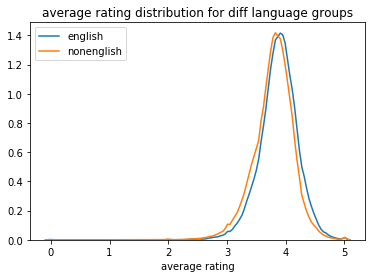

In [62]:
import seaborn as sns
sns.kdeplot(books_lg[books_lg['english'] == 1].average_rating, label='english')
sns.kdeplot(books_lg[books_lg['english'] == 0].average_rating, label='nonenglish')
plt.title('average rating distribution for diff language groups')
plt.xlabel('average rating');

In [63]:
# stats.mannwhitneyu(en_book_rate, nonen_book_rate, 'two-sided' )

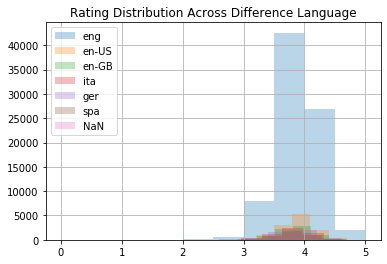

In [64]:
#Rating Distribution Across Difference Language
books_df1[books_df1.language_code == 'eng'].average_rating.hist(bins=10,label='eng', alpha =0.3)
books_df1[books_df1.language_code == 'en-US'].average_rating.hist(bins=10, label='en-US', alpha =0.3)
books_df1[books_df1.language_code == 'en-GB'].average_rating.hist(bins=10, label='en-GB', alpha =0.3)
books_df1[books_df1.language_code == 'ita'].average_rating.hist(bins=10, label='ita', alpha =0.3)
books_df1[books_df1.language_code == 'ger'].average_rating.hist(bins=10, label='ger', alpha =0.3)
books_df1[books_df1.language_code == 'spa'].average_rating.hist(bins=10, label='spa', alpha =0.3)
books_df1[books_df1.language_code.isnull()].average_rating.hist(bins=10, label='NaN', alpha =0.3)
plt.legend()
plt.title('Rating Distribution Across Difference Language');


In [65]:
len(books_df1.ratings_count.unique()), books_df1.ratings_count.unique()

(6966, array([  186,   269,   192, ..., 13605, 14232,  2312]))

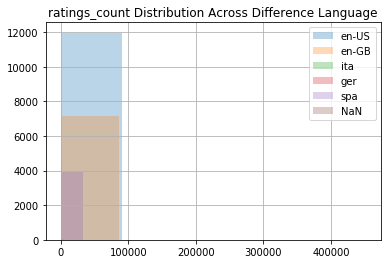

In [66]:
#Rating counts Distribution Across Difference Language
# books_df1[books_df1.language_code == 'eng'].groupby('ratings_count').size().plot(kind='bar', label='eng', alpha =0.3)
books_df1[books_df1.language_code == 'en-US'].ratings_count.hist(bins=5, label='en-US', alpha =0.3)
books_df1[books_df1.language_code == 'en-GB'].ratings_count.hist(bins=5, label='en-GB', alpha =0.3)
books_df1[books_df1.language_code == 'ita'].ratings_count.hist(bins=5, label='ita', alpha =0.3)
books_df1[books_df1.language_code == 'ger'].ratings_count.hist(bins=5, label='ger', alpha =0.3)
books_df1[books_df1.language_code == 'spa'].ratings_count.hist(bins=5, label='spa', alpha =0.3)
books_df1[books_df1.language_code.isnull()].ratings_count.hist(bins=5, label='NaN', alpha =0.3)
plt.legend()
plt.title('ratings_count Distribution Across Difference Language');

In [67]:
len(books_df1.text_reviews_count.unique()), books_df1.text_reviews_count.unique()

(1719, array([  15,   60,   23, ..., 4071, 2179, 1795]))

#### num_pages, is_ebook, rating counts and text review counts

In [68]:
len(books_df1.num_pages.unique()), books_df1.num_pages.unique()

(1156, array([ 400,  318,  321, ..., 1712, 1103, 1239]))

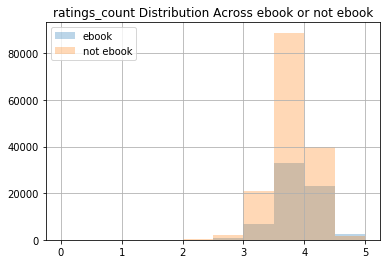

In [69]:
#Rating Distribution Across ebook or not ebook
books_df1[books_df1.is_ebook == 'true'].average_rating.hist(bins=10,label='ebook', alpha =0.3)
books_df1[books_df1.is_ebook == 'false'].average_rating.hist(bins=10, label='not ebook', alpha =0.3)
plt.legend()
plt.title('ratings_count Distribution Across ebook or not ebook');

In [70]:
books_df1.drop(['book_id', 'work_id','isbn','asin', 'country_code'], axis = 1, inplace=True)

### Merge reviews and book graph

In [71]:
book_review = pd.merge(reviews_df1, books_df, on=['book_id'])

In [72]:
len(book_review)

1791519

In [73]:
book_review.columns

Index(['review_id', 'user_id', 'book_id', 'rating', 'timestamp', 'n_votes',
       'n_comments', 'work_id', 'isbn', 'asin', 'title', 'description',
       'num_pages', 'is_ebook', 'link', 'country_code', 'language_code',
       'average_rating', 'ratings_count', 'text_reviews_count', 'author_id',
       'publisher', 'publication_year', 'genre', 'similar_books'],
      dtype='object')

In [74]:
book_review.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,work_id,isbn,asin,...,country_code,language_code,average_rating,ratings_count,text_reviews_count,author_id,publisher,publication_year,genre,similar_books
0,5e212a62bced17b4dbe41150e5bb9037,8842281e1d1347389f2ab93d60773d4d,6392944,3,Mon Jul 24 02:48:17 -0700 2017,6,0,625995,,B000FC2NH6,...,US,eng,3.80,675,42,"[{'author_id': '123715', 'role': ''}]",,,"[{'count': '1572', 'name': 'mystery'}, {'count...","[280990, 1332179, 2008927, 383223, 192888, 311..."
1,ee9cf5e49795718b9bb086c1cde23116,24d87e891f6f60ae101c1de158cbe672,6392944,4,Fri Jun 24 10:34:25 -0700 2011,0,0,625995,,B000FC2NH6,...,US,eng,3.80,675,42,"[{'author_id': '123715', 'role': ''}]",,,"[{'count': '1572', 'name': 'mystery'}, {'count...","[280990, 1332179, 2008927, 383223, 192888, 311..."
2,b5a6af59482018d0814c373723080adb,d083ade0fb4502508b1f3ce59bf1c7db,6392944,4,Wed Aug 27 11:42:41 -0700 2014,0,0,625995,,B000FC2NH6,...,US,eng,3.80,675,42,"[{'author_id': '123715', 'role': ''}]",,,"[{'count': '1572', 'name': 'mystery'}, {'count...","[280990, 1332179, 2008927, 383223, 192888, 311..."
3,4339e08a4eefd80a4e38fb86d50a1ad8,74cd9e03b81085c69ae2dc9fcce17f48,6392944,4,Tue Jan 27 07:05:17 -0800 2015,1,0,625995,,B000FC2NH6,...,US,eng,3.80,675,42,"[{'author_id': '123715', 'role': ''}]",,,"[{'count': '1572', 'name': 'mystery'}, {'count...","[280990, 1332179, 2008927, 383223, 192888, 311..."
4,994211c385e1989f034944dc1e113acb,b6c9716c71c8bfb757a3aee18c1d0be7,6392944,3,Sat Apr 01 13:45:00 -0700 2017,0,0,625995,,B000FC2NH6,...,US,eng,3.80,675,42,"[{'author_id': '123715', 'role': ''}]",,,"[{'count': '1572', 'name': 'mystery'}, {'count...","[280990, 1332179, 2008927, 383223, 192888, 311..."
